# **Cats and Dogs Classifier**

# Introduction

In this project we will explore how CNN architectures of increasing complexity can deal with the classic Cat Vs Dog classification problem. The intention is to see how the extra layers that will be added to the CNN will change the prediction behavior of the model. After taking our liberties with our own architecture, we will also briefly explore more complex models via Transfer Learning, specifically using the ResNet50 model.

## About the dataset

At first, the dataset intended for the training of the models was a personally collected dataset of dogs and cats that was scrapped from various reddit posts. The dataset was collected with the intention of being a hard dataset to train the model on, however it was much harder than expected and the results were not good (~55% accuracy with the baseline model and 90% with ResNet50). Due to to the low accuracy and the small variability of the results after changing the model's architecture, the dataset was deemed unsuitable for the purposes of this project. As such, the training was done using the dataset from the Kaggle competition "Dogs vs. Cats Redux: Kernels Edition".This dataset contains 25000 colored RGB images of dogs and cats. 

\

**Dataset:**

Dogs vs. Cats Redux: Kernels Edition: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data

# Import Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset and Libraries


In [9]:
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [ ]:
# Install kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create necessary directories
! mkdir ~/.kaggle
! mkdir /content/dataset

In [ ]:
# Copy kaggle credentials
! cp /content/drive/MyDrive/Colab_Notebooks/AIDL/Data/kaggle.json ~/.kaggle/

In [ ]:
# Verify credentials
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 800M/814M [00:05<00:00, 170MB/s]
100% 814M/814M [00:05<00:00, 146MB/s]


In [ ]:
# Unzip dataset
! unzip dogs-vs-cats-redux-kernels-edition -d /content/dataset
! rm dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.zip  
  inflating: /content/dataset/train.zip  


In [ ]:
! unzip /content/dataset/train.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/dog.5499.jpg  
  inflating: /content/dataset/train/dog.55.jpg  
  inflating: /content/dataset/train/dog.550.jpg  
  inflating: /content/dataset/train/dog.5500.jpg  
  inflating: /content/dataset/train/dog.5501.jpg  
  inflating: /content/dataset/train/dog.5502.jpg  
  inflating: /content/dataset/train/dog.5503.jpg  
  inflating: /content/dataset/train/dog.5504.jpg  
  inflating: /content/dataset/train/dog.5505.jpg  
  inflating: /content/dataset/train/dog.5506.jpg  
  inflating: /content/dataset/train/dog.5507.jpg  
  inflating: /content/dataset/train/dog.5508.jpg  
  inflating: /content/dataset/train/dog.5509.jpg  
  inflating: /content/dataset/train/dog.551.jpg  
  inflating: /content/dataset/train/dog.5510.jpg  
  inflating: /content/dataset/train/dog.5511.jpg  
  inflating: /content/dataset/train/dog.5512.jpg  
  inflating: /content/dataset/train/dog.5513.jpg  
  inflating: /content/dataset/train

In [ ]:
! mkdir /content/dataset/train/cats
! mkdir /content/dataset/train/dogs
! mkdir /content/dataset/test
! mkdir /content/dataset/test/cats
! mkdir /content/dataset/test/dogs

# Preprocess Images and Change Directories

Each of the images will be resized to 224x224 and then 20% of the images will be randomly assigned to the validation set.

In [3]:
def resize(image_path, final_size):

  """
  Resizes images while keeping the aspect ratio and the remainder until the 
  final size is filled with black.
  """

  # Catch exception if image cannot be loaded
  try:
    # Open Image and convert to RGB
    image = Image.open(image_path).convert('RGB')
  except:
    return None
  
  # Resize and keep ratio
  final_width, final_height = final_size[0], final_size[1]
  background = Image.new('RGB', [final_height, final_width])

  width, height = image.size

  if width > height:
    new_width = final_width
    new_height = round(final_width * height / width)
  else:
    new_height = final_height
    new_width = round(final_height * width / height)

  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

  offset = ((final_width - new_width) // 2, (final_height - new_height) // 2)
  background.paste(resized_image, offset)

  return background

In [ ]:
directory = '/content/dataset/train'
file_list = sorted(os.listdir(directory))


final_width = 224
final_height = 224

train_validation_ratio = 0.2

for filename in tqdm(file_list):
  file_path = os.path.join(directory, filename)  # Build image path name

  # Ignore any folders in directory
  if not os.path.isfile(file_path):
    continue

  resized_image = resize(file_path, (final_width, final_height))
  
  if resized_image is None:
    print(f"Couldn't open image {file_path.split()[-1]}")
    continue
  
  resized_image.save(file_path)
 
  # Randomly assign to test and train sets
  new_dir = '/content/dataset/train'
  if random.random() <= train_validation_ratio:
    new_dir ='/content/dataset/test'

  if 'cat' in filename:
    old_path = os.path.join(directory, filename)
    new_path = os.path.join(new_dir, 'cats', filename)
  elif 'dog' in filename:
    old_path = os.path.join(directory, filename)
    new_path = os.path.join(new_dir, 'dogs', filename)

  os.rename(old_path, new_path)

100%|██████████| 25002/25002 [04:04<00:00, 102.37it/s]


# Plot sample images

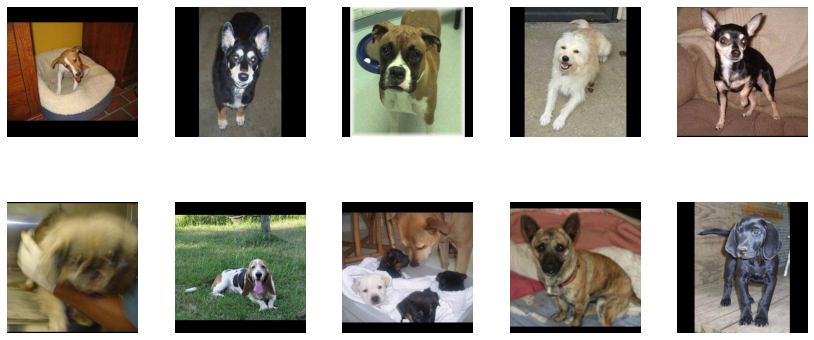

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

folder = '/content/dataset/train/dogs'

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for ax, file in zip(axs.ravel(), os.listdir(folder)):
  filename = os.path.join(folder, file)
  image = imread(filename)
  ax.imshow(image)
  ax.axis('off')

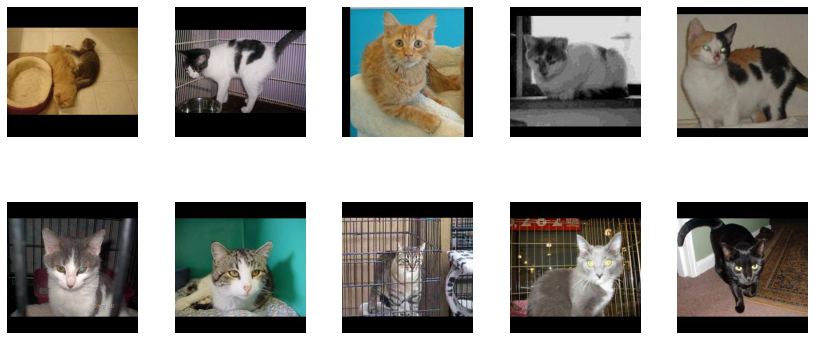

In [ ]:
folder = '/content/dataset/train/cats'

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for ax, file in zip(axs.ravel(), os.listdir(folder)):
  filename = os.path.join(folder, file)
  image = imread(filename)
  ax.imshow(image)
  ax.axis('off')

# Models

Necessary Libraries

In [ ]:
import sys
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

The training of the models will be performed using the function below. Due to the large number of images and the small RAM provided by Google Colab, keras' ImageDataGenerator will be used to create iterators of the images. This will greatly increase the amount of data we can load but it will slow down the training process. Early stopping based on the value of the validation loss is performed and the best model in regards to validation loss is saved. Finally, data augmentation can be performed if selected.

In [ ]:
def train_model(model, save_path, augmentation=False, epochs=10):

  """
  A funtion to train, evaluate and save the model

  model -- input model to train, evaluate and save
  save_path -- path to save the model at
  augmentation -- whether to augment the data or not
  epochs -- the total number of epochs to train the model over
  """
  
  # Image Generators
  if augmentation == False:
    train_iterator = ImageDataGenerator(rescale=1.0/255.0)
  else:
    train_iterator = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rotation_range=40, brightness_range=[0.5, 1.5])
  
  test_iterator = ImageDataGenerator(rescale=1.0/255.0)
  
  # Iterators
  train_generator = train_iterator.flow_from_directory('/content/dataset/train', class_mode='binary', batch_size=64, target_size=(224, 224))
  test_generator = test_iterator.flow_from_directory('/content/dataset/test', class_mode='binary', batch_size=64, target_size=(224, 224))
  
  # Callback object for early stopping and checkpoint
  callbacks = [EarlyStopping(monitor='val_loss', patience=3), ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)]

  # Fit Model
  history = model.fit(train_generator, steps_per_epoch=len(train_generator), callbacks=callbacks, validation_data=test_generator, validation_steps=len(test_generator), epochs=epochs, verbose=1)
  
  # Evaluate Model
  _, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=0)
  print('Accuracy: %.3f %' % (acc * 100.0))

  return history

The function below will be used to plot the models' metrics. Train and test accuracy as well as train and test loss will be plotted against each other.

In [ ]:
def make_plots(history):
  
  """
  A function to plot model's history
  """

  # Plot Accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  # Plot Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

## Baseline Model

First, a simple **Baseline CNN Model** will be created to be used for comparison with other more complex models later on. This model consists of 2 blocks and **7 layers** in total. The nonlinear activation function **ReLU** is used with the exception of the output layer where **sigmoid** is used due to the binarity of the classification. A **Max Pooling** Layer connects the blocks using a 2x2 kernel. Finally the optimizer used was **Adam** and the loss function used is **Binary Crossentropy**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/Baseline_Model.h5'
history = train_model(model, save_path, epochs=20)

Found 20160 images belonging to 2 classes.
Found 4840 images belonging to 2 classes.
Epoch 1/20
315/315 [==============================] - 64s 163ms/step - loss: 0.7105 - accuracy: 0.6018 - val_loss: 0.5985 - val_accuracy: 0.6773
Epoch 2/20
315/315 [==============================] - 49s 156ms/step - loss: 0.5644 - accuracy: 0.7067 - val_loss: 0.5525 - val_accuracy: 0.7174
Epoch 3/20
315/315 [==============================] - 49s 154ms/step - loss: 0.4963 - accuracy: 0.7550 - val_loss: 0.5357 - val_accuracy: 0.7283
Epoch 4/20
315/315 [==============================] - 48s 153ms/step - loss: 0.4036 - accuracy: 0.8179 - val_loss: 0.5308 - val_accuracy: 0.7442
Epoch 5/20
315/315 [==============================] - 48s 153ms/step - loss: 0.2926 - accuracy: 0.8722 - val_loss: 0.5900 - val_accuracy: 0.7471
Epoch 6/20
315/315 [==============================] - 47s 150ms/step - loss: 0.1711 - accuracy: 0.9366 - val_loss: 0.7209 - val_accuracy: 0.7574
Epoch 7/20
315/315 [=========================

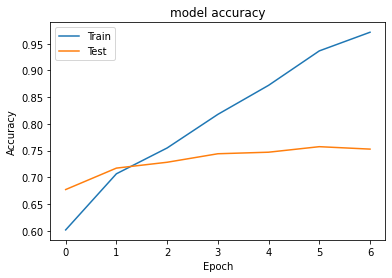

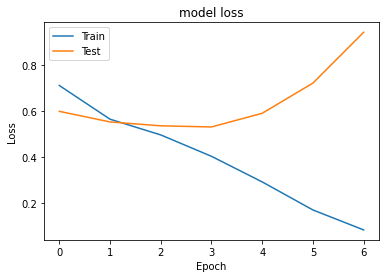

In [ ]:
make_plots(history)

As expected, the baseline model is performing badly with a maximum accuracy of 75%. Despite the fact that test accuracy is slightly yet steadily increasing, interestingly enough test loss starts increasing too after epoch 5. Given that the test accuracy is only so slightly increasing we can assume that the model has reached its maximum accuracy. As such it seems that the model starts to significantly overfit the data after epoch 4.

## Adding an extra Block

This time an **extra** block consisting of a **convolutional** and a max **pooling** layer will be added just before the flatten layer.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/Baseline_Model_2.h5'
history = train_model(model, save_path, epochs=20)

Found 20160 images belonging to 2 classes.
Found 4840 images belonging to 2 classes.
Epoch 1/20
315/315 [==============================] - 50s 155ms/step - loss: 0.6861 - accuracy: 0.5762 - val_loss: 0.6172 - val_accuracy: 0.6651
Epoch 2/20
315/315 [==============================] - 51s 163ms/step - loss: 0.5703 - accuracy: 0.7045 - val_loss: 0.5419 - val_accuracy: 0.7295
Epoch 3/20
315/315 [==============================] - 49s 157ms/step - loss: 0.4927 - accuracy: 0.7606 - val_loss: 0.4879 - val_accuracy: 0.7723
Epoch 4/20
315/315 [==============================] - 49s 154ms/step - loss: 0.4186 - accuracy: 0.8073 - val_loss: 0.4961 - val_accuracy: 0.7750
Epoch 5/20
315/315 [==============================] - 50s 157ms/step - loss: 0.3364 - accuracy: 0.8519 - val_loss: 0.4360 - val_accuracy: 0.8074
Epoch 6/20
315/315 [==============================] - 49s 154ms/step - loss: 0.2437 - accuracy: 0.8977 - val_loss: 0.4851 - val_accuracy: 0.8035
Epoch 7/20
315/315 [=========================

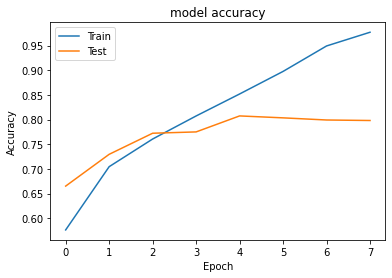

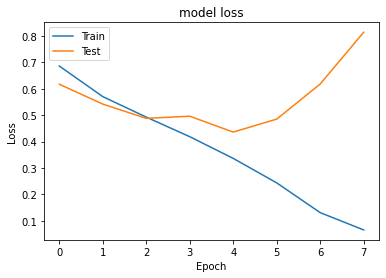

In [ ]:
make_plots(history)

The extra block added seems to benefit the model significantly as this time the accuracy is around 80%. Again the model is rather weak for the dataset and the same overfitting behavior is detected. This time however the model starts significantly overfitting after epoch 5 instead of 4.

## Adding Dropout

Now in between the blocks a **dropout** regularization layer with a rate of 0.2 will be introduced. This CNN architecture is a 3 block VGG-like CNN.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)       

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/Dropout_Model.h5'
history = train_model(model, save_path, epochs=20)

Found 20160 images belonging to 2 classes.
Found 4840 images belonging to 2 classes.
Epoch 1/20
315/315 [==============================] - 50s 156ms/step - loss: 0.7249 - accuracy: 0.5805 - val_loss: 0.6298 - val_accuracy: 0.6345
Epoch 2/20
315/315 [==============================] - 51s 161ms/step - loss: 0.5855 - accuracy: 0.6841 - val_loss: 0.5465 - val_accuracy: 0.7264
Epoch 3/20
315/315 [==============================] - 51s 161ms/step - loss: 0.4988 - accuracy: 0.7550 - val_loss: 0.4745 - val_accuracy: 0.7748
Epoch 4/20
315/315 [==============================] - 50s 159ms/step - loss: 0.4245 - accuracy: 0.8012 - val_loss: 0.4356 - val_accuracy: 0.8004
Epoch 5/20
315/315 [==============================] - 49s 154ms/step - loss: 0.3635 - accuracy: 0.8346 - val_loss: 0.4454 - val_accuracy: 0.7967
Epoch 6/20
315/315 [==============================] - 51s 161ms/step - loss: 0.3015 - accuracy: 0.8673 - val_loss: 0.4264 - val_accuracy: 0.8147
Epoch 7/20
315/315 [=========================

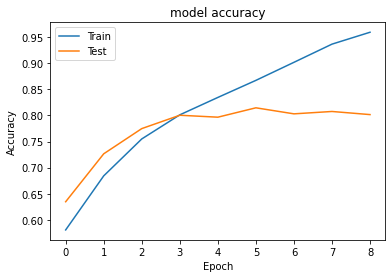

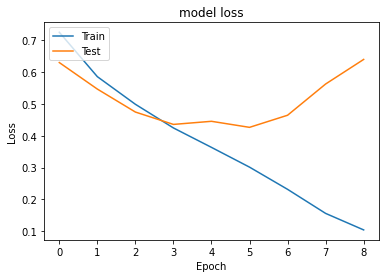

In [ ]:
make_plots(history)

Even after adding the dropout layer the model doesn't seem to improving much. The one main difference is that this time after the regularization the overfitting starts after epoch 6 -instead of 5.

## Adding Data Augmentation

The same model from above will be trained on the dataset using data augmentation. More specifically, after the augmentations the pictures can have slightly modified height or width, might be flipped horizontally or rotated between [-40, 40] degrees and their brightness might be adjusted.

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/Augmentation_Model.h5'
history = train_model(model, save_path, epochs=20, augmentation=True)

Found 20160 images belonging to 2 classes.
Found 4840 images belonging to 2 classes.
Epoch 1/20
315/315 [==============================] - 270s 854ms/step - loss: 0.5944 - accuracy: 0.6945 - val_loss: 0.4406 - val_accuracy: 0.8027
Epoch 2/20
315/315 [==============================] - 266s 845ms/step - loss: 0.5182 - accuracy: 0.7417 - val_loss: 0.4212 - val_accuracy: 0.8107
Epoch 3/20
315/315 [==============================] - 265s 841ms/step - loss: 0.4905 - accuracy: 0.7639 - val_loss: 0.4003 - val_accuracy: 0.8176
Epoch 4/20
315/315 [==============================] - 264s 838ms/step - loss: 0.4715 - accuracy: 0.7743 - val_loss: 0.4046 - val_accuracy: 0.8165
Epoch 5/20
315/315 [==============================] - 265s 840ms/step - loss: 0.4627 - accuracy: 0.7815 - val_loss: 0.3849 - val_accuracy: 0.8349
Epoch 6/20
315/315 [==============================] - 266s 845ms/step - loss: 0.4470 - accuracy: 0.7923 - val_loss: 0.3962 - val_accuracy: 0.8233
Epoch 7/20
315/315 [===================

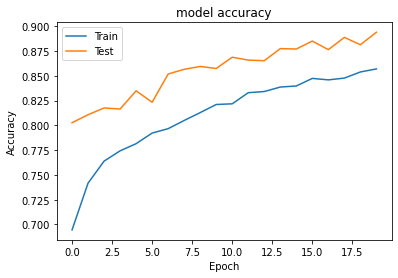

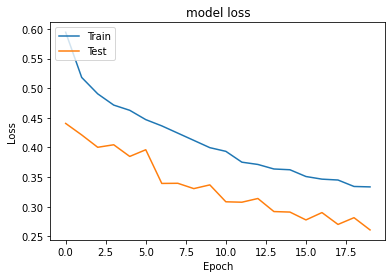

In [ ]:
make_plots(history)

After applying augmentation to the input images before feeding them into the network we can see a huge improvement to the model's performance. This time the test accuracy is almost 90% which is 10% better than the previously best model! What's worth mentioning here is that the model performs best on the test set than on the train set both in terms of loss and accuracy. This is partly due to the dropout regularization but mainly due to the heavy augmentation performed on the training data. Due to that, the training images are much harder to predict than the test ones, creating a more robust model.

The model keeps performing better and better after each epoch until it reached the max number of training epochs. That is strong evidence that the model's performance would further increase if the training was done over more epochs.

# Transfer Learning

We will now briefly explore transfer learning. We will load ResNet50 from Keras except for its top layer. Instead, we'll add our own dense layer.

## ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

model = Sequential()
model.add(ResNet50(include_top=False, pooling='max'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/ResNet50.h5'
history = train_model(model, save_path, epochs=20)

Found 20124 images belonging to 2 classes.
Found 4876 images belonging to 2 classes.
Epoch 1/20
315/315 [==============================] - 224s 697ms/step - loss: 0.6101 - accuracy: 0.8621 - val_loss: 0.9528 - val_accuracy: 0.5269
Epoch 2/20
315/315 [==============================] - 217s 690ms/step - loss: 0.2281 - accuracy: 0.9412 - val_loss: 1.0135 - val_accuracy: 0.6833
Epoch 3/20
315/315 [==============================] - 219s 694ms/step - loss: 0.1478 - accuracy: 0.9576 - val_loss: 0.2565 - val_accuracy: 0.9350
Epoch 4/20
315/315 [==============================] - 219s 694ms/step - loss: 0.1156 - accuracy: 0.9656 - val_loss: 0.1711 - val_accuracy: 0.9590
Epoch 5/20
315/315 [==============================] - 218s 693ms/step - loss: 0.0915 - accuracy: 0.9711 - val_loss: 0.1678 - val_accuracy: 0.9608
Epoch 6/20
315/315 [==============================] - 219s 694ms/step - loss: 0.0753 - accuracy: 0.9751 - val_loss: 0.1615 - val_accuracy: 0.9608
Epoch 7/20
315/315 [===================

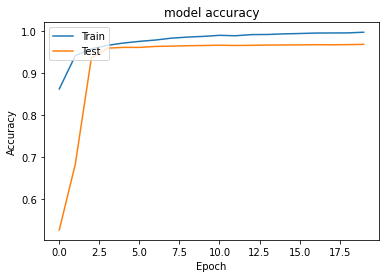

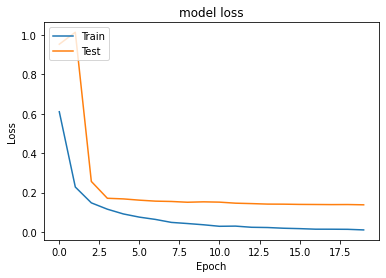

In [ ]:
make_plots(history)

As expected the results are very impressive. The model performs almost 7% better than our previously best model with an overall accuracy of ~97%

# ResNet50 with Augmentation

The exact same model will be train again but this time we're also going to augment the input data.

In [ ]:
save_path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/ResNet50_Augmentation.h5'
history = train_model(model, save_path, augmentation=True, epochs=20)

Found 20046 images belonging to 2 classes.
Found 4954 images belonging to 2 classes.
Epoch 1/20
314/314 [==============================] - 364s 1s/step - loss: 0.3869 - accuracy: 0.9243 - val_loss: 1.2804 - val_accuracy: 0.5046
Epoch 2/20
314/314 [==============================] - 345s 1s/step - loss: 0.1772 - accuracy: 0.9594 - val_loss: 0.5335 - val_accuracy: 0.8139
Epoch 3/20
314/314 [==============================] - 344s 1s/step - loss: 0.1385 - accuracy: 0.9656 - val_loss: 0.1104 - val_accuracy: 0.9697
Epoch 4/20
314/314 [==============================] - 344s 1s/step - loss: 0.1043 - accuracy: 0.9721 - val_loss: 0.0722 - val_accuracy: 0.9828
Epoch 5/20
314/314 [==============================] - 339s 1s/step - loss: 0.0934 - accuracy: 0.9747 - val_loss: 0.0736 - val_accuracy: 0.9828
Epoch 6/20
314/314 [==============================] - 339s 1s/step - loss: 0.0835 - accuracy: 0.9779 - val_loss: 0.0701 - val_accuracy: 0.9832
Epoch 7/20
314/314 [==============================] - 339

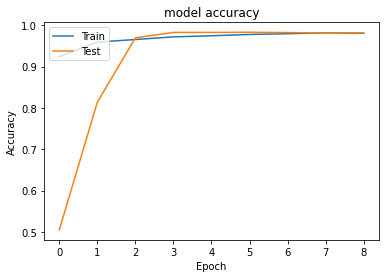

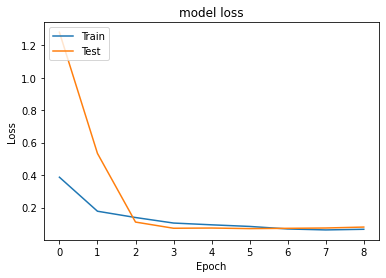

In [ ]:
make_plots(history)

Once again the model shows a significant improvement after using data augmentation. The accuracy on the validation data is ~98% making it the best model of all.

# Implementation

It's time to try the best model with some sample images

In [11]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/CatsVsDogs/ResNet50_Augmentation.h5')

In [17]:
#@title Select an Image Source
import requests
from io import BytesIO

image_source = "Demo5" #@param ["Url", "Upload", "Demo1", "Demo2", "Demo3", "Demo4", "Demo5", "Demo6"]


if image_source == "Url":

  url = input("Paste image url here:")
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Upload":
  from google.colab import files
  image_path = list(files.upload().keys())[0]

elif image_source == "Demo1":
  url = 'https://www.diamondpet.com/wp-content/uploads/2016/09/20160927-PlayKitty_1200x630-1024x538.jpg'
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Demo2":
  url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6SWX6zgGIWt-zCKJlhYFPw97L2N47LjknQg&usqp=CAU'
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Demo3":
  url = 'https://images.theconversation.com/files/350865/original/file-20200803-24-50u91u.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop'
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Demo4":
  url = 'https://ichef.bbci.co.uk/news/976/cpsprodpb/D79D/production/_123979155_gettyimages-1064733482.jpg'
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Demo5":
  url = 'https://pbs.twimg.com/profile_images/805808226730053632/KKGO8WTb_400x400.jpg'
  response = requests.get(url)
  image_path = BytesIO(response.content)

elif image_source == "Demo6":
  url = 'https://images.theconversation.com/files/319375/original/file-20200309-118956-1cqvm6j.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop'
  response = requests.get(url)
  image_path = BytesIO(response.content)

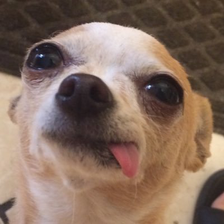


It's a photo of a Dog


In [18]:
image = resize(image_path, [224,224])
results = {0:'Cat', 1:'Dog'}

display(image)

image=np.expand_dims(image,axis=0)
image=np.array(image)
image=image/255

pred = model.predict(image)
pred_class = np.round(model.predict(image)).astype("int32")[0][0]
print(f"\nIt's a photo of a {results[pred_class]}")